## In this project we will use SciPy library to improve our portfolio by achieving the target return. We will calculate the performance of the current portfolio. Also we will use minimize function from the library to find the portfolio which has the target return.
___

# Preparations

### Import libraries

Import standard libraries we need for interaction with data - Numpy and Pandas, for visualization - Matplotlib and Seaborn, for getting financial data - yfinance.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['figure.figsize'] = [12, 6]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.optimize import minimize

import datetime
import yfinance as yf

### Create time boundaries

Creating variables with time boundaries using the datetime library.

In [7]:
end_date = datetime.datetime.now()
start_date = datetime.datetime.now() - datetime.timedelta(days=5*365)

### Init portfolio data

We have the customer portfolio consisting of 13 different stocks with actual weights in it.

In [10]:
portfolio = ['AAPL', 'ABBV', 'BAC', 'BTI', 'C', 'CMCSA', 'FDX',  'GPS', 'HPQ', 'INTC', 'PFE', 'T', 'V']
current_weights = [0.1269, 0.1082, 0.0473, 0.0762, 0.0441, 0.0627, 0.1069, 0.1006, 0.0716, 0.0401, 0.0588, 0.0689, 0.0876]
portfolio_len = len(portfolio)

# Calculate target returns

### Load the stock data

Load the daily stock data within the 5-year time period by using yfinance.

In [14]:
stock_data = yf.download(portfolio, start_date, end_date, interval='1d')
stock_data = stock_data['Close']
stock_data = stock_data.reset_index()

[*********************100%***********************]  13 of 13 completed


### Calculate metrics

Calculate the basic metrics - historical mean return and covariance matrix.

In [17]:
# Find the quarterly return for each period
selected = list(stock_data.columns[1:])
returns = stock_data[selected].pct_change()
# Find the expected returns 
expected_returns = returns.mean()
# Find the covariance 
cov = returns.cov()

### Calculate target portfolio

Define the target return. We can achieve 17% yield.

In [20]:
target_return = 0.17

We aim to achieve a highly diversified portfolio by setting both minimum and maximum percentage limits, ensuring that each stock's allocation falls within this range in the final portfolio.

In [22]:
min_stock_fraction = 1/(portfolio_len*2)
max_stock_fraction = 2/portfolio_len

bounds = tuple((min_stock_fraction, max_stock_fraction) for i in range(portfolio_len))

We have the obvious condition that sum of weights has to be 1. The second one we have the condition to achieve the target return.

In [24]:
cons = (
    # Sum of weights must equate to 1
    {'type' : 'eq', 'fun' : lambda w : np.sum(w) - 1},
    # Difference between expected return and target must be equal to 0.
    {'type' : 'eq', 'fun' : lambda x : x.dot(expected_returns) * 252 - target_return})

Define a function which returns the annualised return.

In [26]:
def getPortReturn(weights):
    return np.dot(np.transpose(weights), expected_returns) * 252

Now we ready to call our implemention.

In [28]:
results = minimize(fun=getPortReturn,
                   x0=current_weights, 
                   bounds=bounds,
                   constraints=cons)  
print(results)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.16999999997261847
       x: [ 1.538e-01  1.244e-01 ...  4.297e-02  8.695e-02]
     nit: 2
     jac: [ 3.233e-01  2.240e-01 ... -1.559e-02  1.282e-01]
    nfev: 28
    njev: 2


# Results

Calculate the performance of the current portfolio.

In [31]:
current_return = getPortReturn(current_weights)
current_volatility = np.sqrt(np.dot(np.transpose(current_weights), np.dot(cov, current_weights)))*np.sqrt(252)

Calculate the performance of the target portfolio.

In [33]:
target_weights = [float(round(x, 4)) for x in results['x']]

In [34]:
target_return = getPortReturn(target_weights)
target_volatility = np.sqrt(np.dot(np.transpose(target_weights), np.dot(cov, target_weights)))*np.sqrt(252)

Collect portfolios to one DataFrame.

In [36]:
current_portfolio = pd.DataFrame(current_weights, index=portfolio, columns=['Current weights'])
target_portfolio = pd.DataFrame(target_weights, index=portfolio, columns=['Target weights'])

portfolios = pd.concat([current_portfolio, target_portfolio], axis=1)

portfolios

,Current weights,Target weights
AAPL,0.1269,0.1538
ABBV,0.1082,0.1244
BAC,0.0473,0.0465
BTI,0.0762,0.0595
C,0.0441,0.0385
CMCSA,0.0627,0.0434
FDX,0.1069,0.1172
GPS,0.1006,0.1207
HPQ,0.0716,0.0892
INTC,0.0401,0.0385


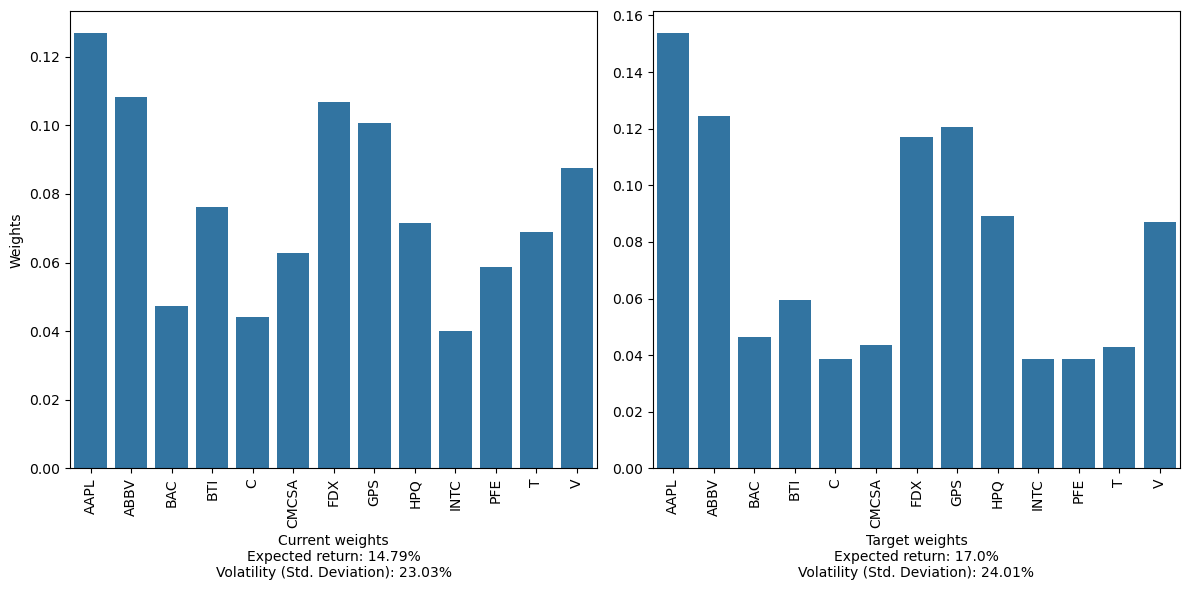

In [53]:
ax1 = plt.subplot(1,2,1)
sns.barplot(x=portfolios.index, y=portfolios['Current weights'])
plt.ylabel("Weights");
plt.xlabel(f"Current weights\nExpected return: {round(current_return*100,2)}%\nVolatility (Std. Deviation): {round(current_volatility*100,2)}%");
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
plt.tight_layout()

ax2 = plt.subplot(1,2,2)
sns.barplot(x=portfolios.index, y=portfolios['Target weights'])
plt.ylabel("");
plt.xlabel(f"Target weights\nExpected return: {round(target_return*100,2)}%\nVolatility (Std. Deviation): {round(target_volatility*100,2)}%");
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
plt.tight_layout()

plt.show()

As the results show, using optimization methods we can achieve the target return our portfolio but with slightly increase volatility.